In [1]:
import numpy as np
import pandas as pd
import cv2
import math
import matplotlib.pyplot as plt
import scipy.io
import random

In [2]:
# import image
image1 = cv2.imread('img1.png')
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)   # BGR -> RGB 
print (type(image1_rgb))

image2 = cv2.imread('img2.png')
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)   # BGR -> RGB 
print (type(image2_rgb))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [3]:
# import inlier points
f = scipy.io.loadmat('points_inliers.mat')
inlier_points1 = np.array(f['X1'])
inlier_points2 = np.array(f['X2'])

# Part a

## compute fundemental matrxi

In [4]:
inlier_f_matrix = cv2.findFundamentalMat(inlier_points1, inlier_points2, cv2.FM_8POINT)

In [5]:
inlier_f_matrix

(array([[-2.14265798e-09,  8.82805686e-08, -1.74996193e-04],
        [ 2.63282800e-07, -8.20895023e-09,  4.93666210e-03],
        [-3.99699256e-04, -5.54555316e-03,  1.00000000e+00]]),
 array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8))

## show points and epipolar lines

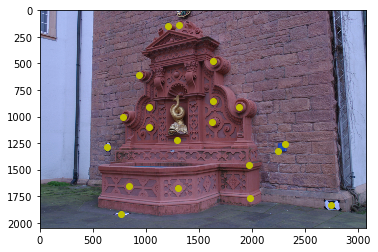

In [6]:
# epipolar lines from view 2 to view 1
plt.imshow(image1_rgb)
plt.plot(inlier_points1[:,0], inlier_points1[:,1], 'yo')

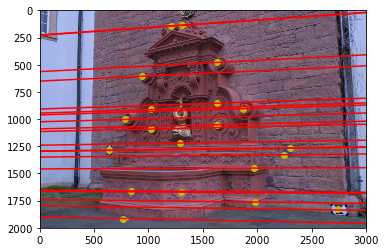

In [7]:
plt.axis([0, 3000, 2000, 0])
plt.imshow(image1_rgb)
plt.plot(inlier_points1[:,0], inlier_points1[:,1], 'yo')
for i in range(len(inlier_points2)):
    t = np.matmul(np.array([np.append(inlier_points2[i], [1])]), inlier_f_matrix[0])[0]
    x = np.linspace(0,3000,100)
    y = (-t[2] -x * t[0])/ t[1]
    plt.plot(x, y, '-r')

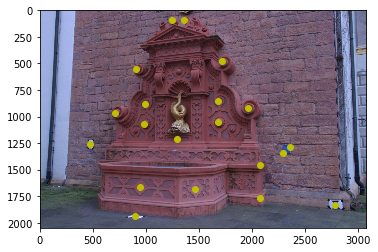

In [8]:
# epipolar lines from view 1 to view 2
plt.imshow(image2_rgb)
plt.plot(inlier_points2[:,0], inlier_points2[:,1], 'yo')

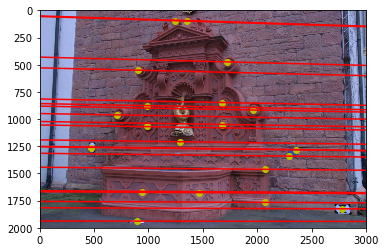

In [9]:
plt.axis([0, 3000, 2000, 0])
plt.imshow(image2_rgb)
plt.plot(inlier_points2[:,0], inlier_points2[:,1], 'yo')
for i in range(len(inlier_points1)):
    t = np.matmul(inlier_f_matrix[0], np.array([np.append(inlier_points1[i], [1])]).transpose())[:,0]
    x = np.linspace(0,3000,100)
    y = (-t[2] -x * t[0])/ t[1]
    plt.plot(x, y, '-r')

# Part b

In [10]:
# calculate the iterations which is needed
p = 99/100
w = 0.5
n = math.ceil(math.log10(1 - p)/math.log10(1 - (1 - w) ** 8))
print(n)

1177


In [11]:
# import points
f = scipy.io.loadmat('points.mat')
points1 = np.array(f['X1'])
points2 = np.array(f['X2'])

In [21]:
# compute fundamental matrix using 8-algorithm and ransac
max_inliers = 0
for i in range(n):
    # select 8 random point
    a = list(range(len(points1)))
    random.shuffle(a)
    subgroup1 = points1[a[0:8]]
    subgroup2 = points2[a[0:8]]
    
    # calculate fundamental matrix
    f_matrix = cv2.findFundamentalMat(subgroup1, subgroup2, cv2.FM_8POINT)
    
    # calculate inliers
    inliers_count = 0
    for j in range(len(points1)):
        d1 = np.matmul(np.array([np.append(points2[j], [1])]), 
                     np.matmul(f_matrix[0], np.array([np.append(points1[j], [1])]).transpose())
                     )
        d2 = np.matmul(f_matrix[0], np.array([np.append(points1[j], [1])]).transpose())
        d3 = np.matmul(np.array([np.append(points2[j], [1])]), f_matrix[0])
        distance = (d1[0,0] ** 2) * (
            1 / (d2[0,0] ** 2 + d2[1,0] ** 2) + 1/ (d3[0,0] ** 2 + d3[0,1] ** 2))
        if(distance <= 3):
            inliers_count += 1
    if(inliers_count > max_inliers):
        max_inliers = inliers_count
        best_f = f_matrix
        best_index = a[0:8]
        
print(max_inliers)
print(best_f)
print(best_index)

11
(array([[ 2.00194789e-08,  2.53309203e-07, -1.72040467e-04],
       [ 7.24222463e-08,  3.06695244e-08,  4.56891608e-03],
       [-4.48350149e-04, -5.18628380e-03,  1.00000000e+00]]), array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8))
[27, 31, 37, 9, 29, 16, 34, 5]


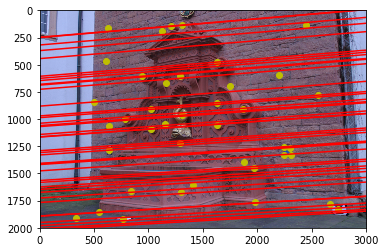

In [25]:
plt.axis([0, 3000, 2000, 0])
plt.imshow(image1_rgb)
plt.plot(points1[:,0], points1[:,1], 'yo')
for i in range(len(points2)):
    t = np.matmul(np.array([np.append(points2[i], [1])]), best_f[0])[0]
    x = np.linspace(0,3000,100)
    y = (-t[2] -x * t[0])/ t[1]
    plt.plot(x, y, '-r')

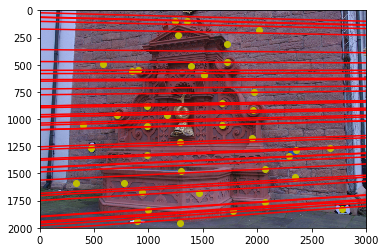

In [26]:
plt.axis([0, 3000, 2000, 0])
plt.imshow(image2_rgb)
plt.plot(points2[:,0], points2[:,1], 'yo')
for i in range(len(points1)):
    t = np.matmul(best_f[0], np.array([np.append(points1[i], [1])]).transpose())[:,0]
    x = np.linspace(0,3000,100)
    y = (-t[2] -x * t[0])/ t[1]
    plt.plot(x, y, '-r')

# Part c

In [13]:
# import points
f = scipy.io.loadmat('info.mat')
real_f = np.array(f['F'])

In [14]:
# real F
print(real_f)

[[-6.80998063e-09  1.18173885e-08 -1.08932371e-04]
 [ 3.47852883e-07 -3.40933672e-09  4.74923600e-03]
 [-4.61831877e-04 -5.37556235e-03  1.00000000e+00]]


In [15]:
# part a F
print(inlier_f_matrix[0])

[[-2.14265798e-09  8.82805686e-08 -1.74996193e-04]
 [ 2.63282800e-07 -8.20895023e-09  4.93666210e-03]
 [-3.99699256e-04 -5.54555316e-03  1.00000000e+00]]


In [16]:
# part b F
print(best_f[0])

[[-4.47864681e-08 -2.28961204e-06  3.52342923e-03]
 [ 2.82473487e-06 -1.32675523e-07  1.10658428e-03]
 [-4.28218942e-03 -1.53177019e-03  1.00000000e+00]]


## difference between part a and real F

### compare part b and a with real f using inlier points of part a and image 1 (draw epilipolar geometry of image 1)

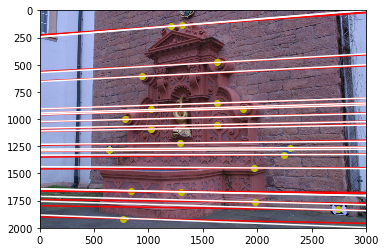

In [17]:
# white == real f
# red == using inlier points to calc f

plt.axis([0, 3000, 2000, 0])
plt.imshow(image1_rgb)
plt.plot(inlier_points1[:,0], inlier_points1[:,1], 'yo')
for i in range(len(inlier_points2)):
    t = np.matmul(np.array([np.append(inlier_points2[i], [1])]), inlier_f_matrix[0])[0]
    x = np.linspace(0,3000,100)
    y = (-t[2] -x * t[0])/ t[1]
    plt.plot(x, y, '-r')
    
for i in range(len(inlier_points2)):
    t = np.matmul(np.array([np.append(inlier_points2[i], [1])]), real_f)[0]
    x = np.linspace(0,3000,100)
    y = (-t[2] -x * t[0])/ t[1]
    plt.plot(x, y, '-w')

## difference between part b and real F

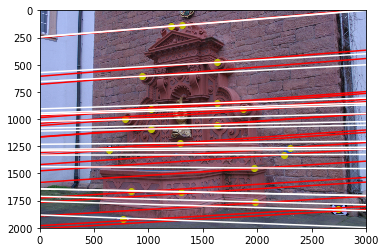

In [22]:
# white == real f
# red == using inlier and outlier points to calc f

plt.axis([0, 3000, 2000, 0])
plt.imshow(image1_rgb)
plt.plot(inlier_points1[:,0], inlier_points1[:,1], 'yo')
for i in range(len(inlier_points2)):
    t = np.matmul(np.array([np.append(inlier_points2[i], [1])]), best_f[0])[0]
    x = np.linspace(0,3000,100)
    y = (-t[2] -x * t[0])/ t[1]
    plt.plot(x, y, '-r')
    
for i in range(len(inlier_points2)):
    t = np.matmul(np.array([np.append(inlier_points2[i], [1])]), real_f)[0]
    x = np.linspace(0,3000,100)
    y = (-t[2] -x * t[0])/ t[1]
    plt.plot(x, y, '-w')